This notebook will demonstrate how to use SequentialMonteCarlo.jl for a Hidden Markov Model with Lotka-Volterra dynamics.

First we load the necessary packages.

In [7]:
using SequentialMonteCarlo
using Distributions
using Catalyst
using JumpProcesses
using DelimitedFiles
using Statistics
using Plots

Next load in the observed data

In [8]:
ts = 1.0:1.0:50.0
n = 50
y = readdlm("prey_pred.csv", ',', Int64)

1.0:1.0:50.0

SequentialMonteCarlo.jl is a flexible package for designing SMC algorithms. It has three major components:
- Particle structure
- Mutation function (includes initial distribution)
- Potential function (log-scale)

The first step is to define the type of particle the algorithm will manipulate.

In [9]:
mutable struct LVParticle
    prey::Int64
    pred::Int64
    LVParticle() = new() # initialise empty
end

In order to define the mutation function, we need to define how the Markov Process evolves. 

In julia we can use JumpProcesses.jl to simulate integer-valued Markov Jump Processes. One way to do this is with the Catalyst.jl reaction network syntax.

In [10]:
lveqns = @reaction_network begin
    c1, prey --> 2*prey         # prey reproduction
    c2, prey + pred --> 2*pred  # prey death, pred reproduction
    c3, pred --> 0              # pred death
end

rates = (:c1 => 0.5, :c2 => 0.0025, :c3 => 0.3)
initial = [71, 79] # latent at time 0.0

2-element Vector{Int64}:
 71
 79

Using the above spefication, we can define a mutation kernel for SequentialMonteCarlo.jl to use.

In [11]:
# mutation kernel
function M!(newParticle::LVParticle, rng, t::Int64, oldParticle::LVParticle, ::Nothing)
    if t == 1
        u0 = initial
        tspan = (0.0, ts[1])
    else
        u0 = [oldParticle.prey, oldParticle.pred]
        tspan = (ts[t-1], ts[t])
    end
    
    dprobt = DiscreteProblem(lveqns, u0, tspan, rates)
    jprobt = JumpProblem(lveqns, dprobt, Direct(), rng = rng)
    res = solve(jprobt, SSAStepper())

    newParticle.prey = res(ts[t])[1]
    newParticle.pred = res(ts[t])[2]
end

M! (generic function with 1 method)

Last we have the potential function.

In [12]:
function lG(t::Int64, particle::LVParticle, ::Nothing)
    preydist = Poisson(0.5*particle.prey)
    preddist = Poisson(0.8*particle.pred)
    return logpdf(preydist, y[1,t]) + logpdf(preddist, y[2,t])
end

lG (generic function with 1 method)

To run the SMC algorithm we need to specify the number of particles $N$, number of threads, the resampling threshold in terms of the relative ESS, and whether to save all the output (instead of just the terminal particles).

In [13]:
N = 2^10
threads = 1
κ = 0.5 # relative ESS threshold
saveall = true

true

The complete SMC model can be specified by

In [14]:
model = SMCModel(M!, lG, n, LVParticle, Nothing)

SMCModel{typeof(M!), typeof(lG)}(M!, lG, 50, LVParticle, Nothing)

and we make a location to save the output from running the algorithm

In [15]:
smcio = SMCIO{model.particle, model.pScratch}(N, n, threads, saveall, κ)
smcio.N

SMCIO{LVParticle, Nothing}(4096, 50, 1, LVParticle[LVParticle(5591577680, 0), LVParticle(5591577984, 0), LVParticle(5886091088, -1152921504606846976), LVParticle(5886091664, -1152921504606846976), LVParticle(5886092176, -1152921504606846976), LVParticle(5886092688, -1152921504606846976), LVParticle(4379050288, 5581744688), LVParticle(112, 5874872832), LVParticle(5886093200, 0), LVParticle(5886093264, 0)  …  LVParticle(5904191312, 72621647814721537), LVParticle(5904191696, -1152921504606846976), LVParticle(5904191760, -1152921504606846976), LVParticle(5590489952, 0), LVParticle(5590490256, 0), LVParticle(5590490560, 0), LVParticle(5590490864, 1), LVParticle(5582055696, 5901534976), LVParticle(5590491168, 0), LVParticle(5590491472, 1)], [0, 57, 5819580928, 4294994034, 0, 0, 0, 4294993936, 0, 0  …  -4096, 5820378776, -4096, 5820345592, -4096, 5820379232, -4096, 5820378624, -4096, 5820379536], [0.0, 2.875647255e-314, 2.8752550097e-314, 2.8756493067e-314, NaN, 2.8756495745e-314, NaN, NaN, N

Then we can run the model using

In [16]:
smc!(model, smcio) # overwrites smcio

We can plot the results as follows

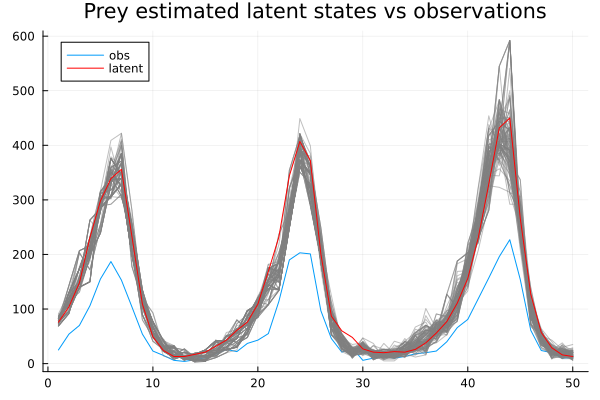

In [19]:
# load true latent states
x = readdlm("prey_pred_true_latent.csv", ',', Int64)

plot(y[1,:], label="obs", title = "Prey estimated latent states vs observations")
pids = sample(1:smcio.N, 100)
for i in pids
    anc = getindex.(smcio.allEves, i)
    u = getindex.(smcio.allZetas, reverse(anc))
    plot!(getfield.(u, :prey), color = "grey", alpha = 0.5, label = "")
end
plot!(x[1,:], label="latent", color = "red")

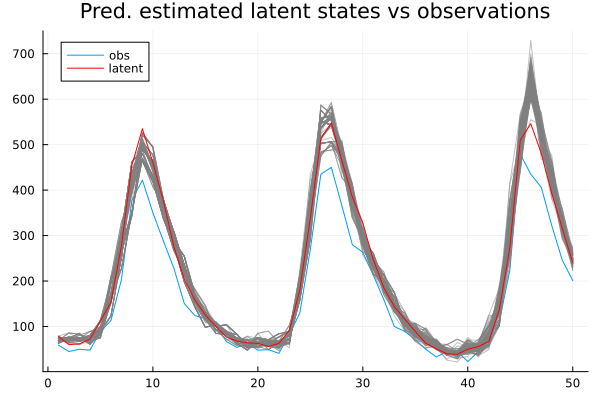

In [20]:
plot(y[2,:], label="obs", title = "Pred. estimated latent states vs observations")
pids = sample(1:smcio.N, 100)
for i in pids
    anc = getindex.(smcio.allEves, i)
    u = getindex.(smcio.allZetas, reverse(anc))
    plot!(getfield.(u, :pred), color = "grey", alpha = 0.5, label = "")
end
plot!(x[2,:], label="latent", color = "red")